In [20]:
# for r in np.arange(1000,21000,1000):
#     MAX_NB_WORDS = r
#     # prepare embedding matrix
#     num_words = min(MAX_NB_WORDS, len(word_index))
#     embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
#     for word, i in word_index.items():
#         if i >= MAX_NB_WORDS:
#             continue
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             # words not found in embedding index will be all-zeros.
#             embedding_matrix[i] = embedding_vector

#     # load pre-trained word embeddings into an Embedding layer
#     # note that we set trainable = False so as to keep the embeddings fixed
#     embedding_layer = Embedding(num_words,
#                                 EMBEDDING_DIM,
#                                 weights=[embedding_matrix],
#                                 input_length=MAX_SEQUENCE_LENGTH,
#                                 trainable=False)
#     b = np.sum(np.argmax(embedding_matrix, axis=1) == 0)

#     print("{} words excluded from [{}x300] embedding matrix:{:.2f}%".format(b, r, (b/r)*100))
#     print()

72 words excluded from [1000x300] embedding matrix:7.20%

182 words excluded from [2000x300] embedding matrix:9.10%

311 words excluded from [3000x300] embedding matrix:10.37%

469 words excluded from [4000x300] embedding matrix:11.72%

645 words excluded from [5000x300] embedding matrix:12.90%

830 words excluded from [6000x300] embedding matrix:13.83%

1049 words excluded from [7000x300] embedding matrix:14.99%

1287 words excluded from [8000x300] embedding matrix:16.09%

1548 words excluded from [9000x300] embedding matrix:17.20%

1805 words excluded from [10000x300] embedding matrix:18.05%

2111 words excluded from [11000x300] embedding matrix:19.19%

2457 words excluded from [12000x300] embedding matrix:20.47%

2769 words excluded from [13000x300] embedding matrix:21.30%

3155 words excluded from [14000x300] embedding matrix:22.54%

3534 words excluded from [15000x300] embedding matrix:23.56%

3922 words excluded from [16000x300] embedding matrix:24.51%

4353 words excluded from [

In [1]:
from keras import backend as K

def fbeta(y_true, y_pred, threshold_shift=0, beta=1):

   # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

   # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

Using TensorFlow backend.


In [2]:
from __future__ import print_function
%matplotlib inline
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
import pandas as pd 
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard

BASE_DIR = '/home/adamszabunio'
MAX_SEQUENCE_LENGTH = 80
MAX_NB_WORDS = 11000
EMBEDDING_DIM = 300

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join(BASE_DIR, 'deps.words'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 174015 word vectors.


In [4]:
wine_df = pd.read_csv('winemag_data_first150k.csv')

clean_wine_df = wine_df.drop_duplicates(subset='description', keep='last')

In [5]:
X = clean_wine_df.description
y = pd.get_dummies(clean_wine_df.variety)

X.shape, y.shape

((97821,), (97821, 632))

In [6]:
texts = [descript for descript in X]

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

In [7]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

labels = np.asarray(y)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=.2, random_state=42)

Shape of data tensor: (97821, 80)
Shape of label tensor: (97821, 632)


In [8]:
data[0]

array([   6, 1691,  400,  415,    8, 3015,   24, 2595,    1,  333,  306,
        119,  597,   64,   10,   40,  105,   38,   22,   13,    1,    3,
       1152,  172,    4,  294, 3175,    2,   23,  810,   30,  139,  102,
         21,    1,    3,  367,  605, 1287,   10,    2,  697,   86,    1,
       2259,   24,  670,   12,   18,   11,   26,   64, 1808,    4,   11,
         12,  384,  959, 1298,  538,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

In [9]:
print('Preparing embedding matrix.')
# prepare embedding matrix
count = 0
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        count += 1
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print("Excluding {} embeddings. These embeddings will be all zeros".format(count))

Preparing embedding matrix.
Excluding 26143 embeddings. These embeddings will be all zeros


In [10]:
print('Building model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(y.shape[1], activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc', fbeta, precision, recall])

model.summary()

Building model.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 300)           3300000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 76, 128)           192128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 38, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 34, 128)           82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 17, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 13, 128)           82048

In [11]:
tb_callback = TensorBoard(log_dir='./w2vec3pool')

In [12]:
hist = model.fit(x_train, y_train,
          batch_size=128,
          epochs=20,
          validation_data=(x_val, y_val),
          callbacks=[tb_callback])

Train on 78256 samples, validate on 19565 samples
Epoch 1/20
78256/78256 [==============================] - 18s - loss: 3.9301 - acc: 0.1041 - fbeta: 0.0011 - precision: 0.0386 - recall: 6.3893e-04 - val_loss: 3.7543 - val_acc: 0.1208 - val_fbeta: 0.0097 - val_precision: 0.4423 - val_recall: 0.0049
Epoch 2/20
78256/78256 [==============================] - 18s - loss: 3.3771 - acc: 0.2112 - fbeta: 0.1049 - precision: 0.7674 - recall: 0.0581 - val_loss: 3.0981 - val_acc: 0.2767 - val_fbeta: 0.2348 - val_precision: 0.7060 - val_recall: 0.1415
Epoch 3/20
78256/78256 [==============================] - 18s - loss: 2.8412 - acc: 0.3180 - fbeta: 0.2489 - precision: 0.8286 - recall: 0.1477 - val_loss: 2.7912 - val_acc: 0.3464 - val_fbeta: 0.2708 - val_precision: 0.8414 - val_recall: 0.1623
Epoch 4/20
78256/78256 [==============================] - 18s - loss: 2.5783 - acc: 0.3763 - fbeta: 0.3213 - precision: 0.8249 - recall: 0.2009 - val_loss: 2.5577 - val_acc: 0.3924 - val_fbeta: 0.3317 - val_p

In [13]:
score = model.evaluate(x_val, y_val, batch_size=128)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test fbeta:', score[2])
print('Test Precision:', score[3])
print('Test Recall:', score[4])

19328/19565 [============================>.] - ETA: 0sTest loss: 3.06820019089
Test accuracy: 0.469051878371
Test fbeta: 0.489978357281
Test Precision: 0.664058855556
Test Recall: 0.389010988991


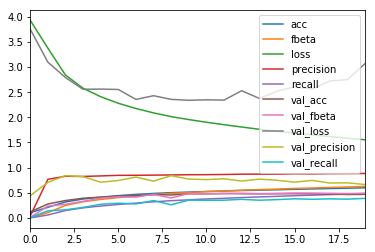

In [14]:
pd.DataFrame(hist.history).plot();

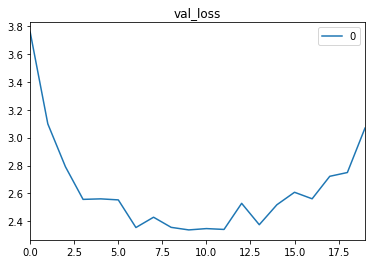

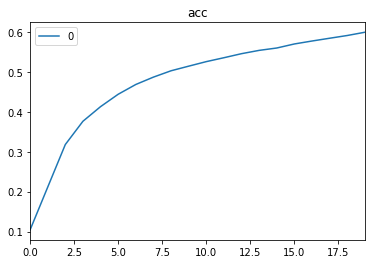

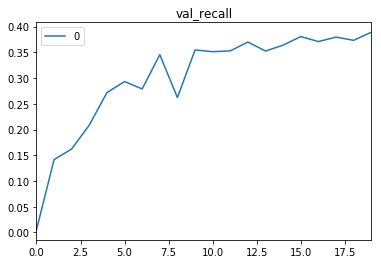

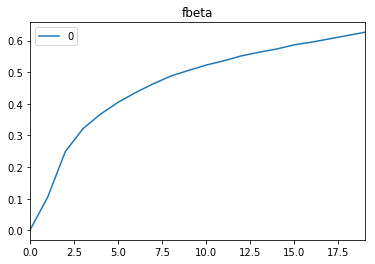

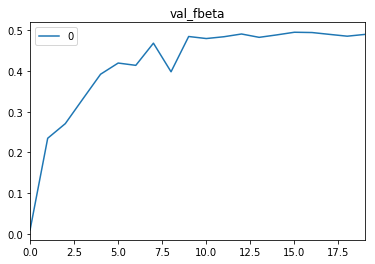

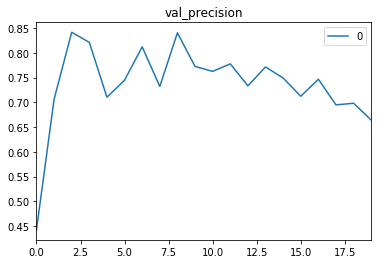

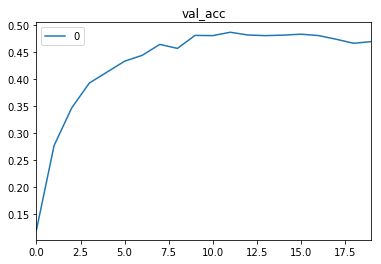

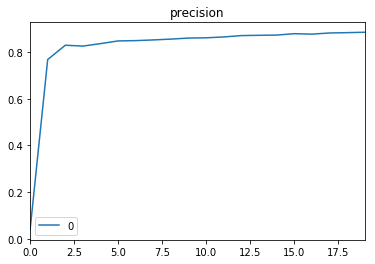

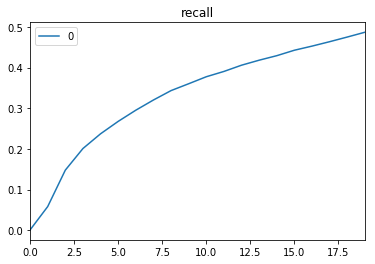

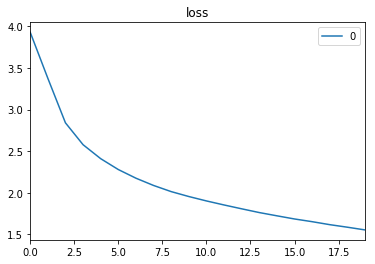

In [15]:
a = [k for k,v in hist.history.items()]
for ky in a:
    pd.DataFrame(hist.history[ky]).plot(title=ky);